In [1]:
%%bash
pip install --upgrade tensorflow
pip install --upgrade tensorflow-gpu
pip install --upgrade keras

  Using cached https://files.pythonhosted.org/packages/dc/29/162476fd44203116e7980cfbd9352eef9db37c49445d1fec35509022f6aa/scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/51/bd/23c926cd341ea6b7dd0b2a00aba99ae0f828be89d72b2190f27c11d4b7fb/requests-2.22.0-py2.py3-none-any.whl
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: requests 2.20.0
    Uninstalling requests-2.20.0:
      Successfully uninstalled requests-2.20.0
  Found existing installation: six 1.11.0
    Uninstalling six-1.11.0:
      Successfully uninstalled six-1.11.0
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1
  Found existing

ERROR: tensorflow-serving-api 1.15.0 has requirement tensorflow~=1.15.0, but you'll have tensorflow 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.10.1 which is incompatible.


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
print(tf.__version__)

2.1.0


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1785432584051257219, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8844703625081617581
 physical_device_desc: "device: XLA_CPU device"]

In [4]:
#tf.enable_eager_execution()
tf.executing_eagerly()

True

In [5]:
# ユニコードファイルを ascii に変換
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = w.rstrip().strip()

    # 文の開始と終了のトークンを付加
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = '<start> ' + w + ' <end>'
    return w

In [6]:
en_sentence = "i can 't tell who will arrive first ."
ja_sentence = "誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(ja_sentence))

<start> i can 't tell who will arrive first . <end>
<start> 誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。 <end>


In [7]:
def create_dataset(path, num_examples):
    with open(path) as f:
        word_pairs = f.readlines()
    word_pairs = [preprocess_sentence(sentence) for sentence in word_pairs]

    return word_pairs[:num_examples]

In [8]:
path_train_en = 'small_parallel_enja/train.en'
path_train_ja = 'small_parallel_enja/train.ja'
en = create_dataset(path_train_en, None)
ja = create_dataset(path_train_ja, None)
print(en[-1])
print(ja[-1])

<start> he thought irritably . <end>
<start> 彼 は いらだ ち ながら 思 っ た 。 <end>


In [9]:
en[0:10]

["<start> i can 't tell who will arrive first . <end>",
 '<start> many animals have been destroyed by men . <end>',
 "<start> i 'm in the tennis club . <end>",
 '<start> emi looks happy . <end>',
 '<start> please bear this fact in mind . <end>',
 '<start> she takes care of my children . <end>',
 '<start> we want to be international . <end>',
 '<start> you ought not to break your promise . <end>',
 '<start> when you cross the street , watch out for cars . <end>',
 '<start> i have nothing to live for . <end>']

In [10]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [11]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<unk>')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [12]:
def load_dataset(path, num_examples=None):
    # クリーニングされた入力と出力のペアを生成
    lang = create_dataset(path, num_examples)

    tensor, lang_tokenizer = tokenize(lang)

    return tensor, lang_tokenizer

In [13]:
# このサイズのデータセットで実験
num_examples = None
input_tensor, inp_lang = load_dataset(path_train_en, num_examples)
target_tensor, targ_lang = load_dataset(path_train_ja, num_examples)
# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [14]:
max_length_targ

18

In [15]:
# 80-20で分割を行い、訓練用と検証用のデータセットを作成
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 長さを表示
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

40000 40000 10000 10000


In [16]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [17]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
2 ----> <start>
10 ----> he
9 ----> is
830 ----> taller
91 ----> than
27 ----> his
86 ----> father
4 ----> .
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
15 ----> 彼
5 ----> は
40 ----> お
100 ----> 父
126 ----> さん
116 ----> より
334 ----> 背
14 ----> が
179 ----> 高
6 ----> い
4 ----> 。
3 ----> <end>


In [18]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [19]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 18]), TensorShape([64, 18]))

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [21]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)



In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # スコアを計算するためにこのように加算を実行する
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # スコアを self.V に適用するために最後の軸は 1 となる
        # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights の shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector の合計後の shape == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(10)


In [24]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # アテンションのため
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output の shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 結合したベクトルを GRU 層に渡す
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)



In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [27]:
checkpoint_dir = 's3://e-qual-task/0131-default/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [28]:
checkpoint_prefix

's3://e-qual-task/0131/ckpt'

In [29]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher Forcing - 正解値を次の入力として供給
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # Teacher Forcing を使用
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [36]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # 2 エポックごとにモデル（のチェックポイント）を保存
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.1246
Epoch 1 Batch 100 Loss 2.8181
Epoch 1 Batch 200 Loss 2.6713
Epoch 1 Batch 300 Loss 2.3203
Epoch 1 Batch 400 Loss 2.1878
Epoch 1 Batch 500 Loss 2.1744
Epoch 1 Batch 600 Loss 2.1385
Epoch 1 Loss 2.5123
Time taken for 1 epoch 199.56905460357666 sec

Epoch 2 Batch 0 Loss 1.9735
Epoch 2 Batch 100 Loss 1.7874
Epoch 2 Batch 200 Loss 1.8885
Epoch 2 Batch 300 Loss 1.9693
Epoch 2 Batch 400 Loss 1.7686
Epoch 2 Batch 500 Loss 1.7896
Epoch 2 Batch 600 Loss 1.7498
Epoch 2 Loss 1.8711
Time taken for 1 epoch 219.34211611747742 sec

Epoch 3 Batch 0 Loss 1.5854
Epoch 3 Batch 100 Loss 1.6580
Epoch 3 Batch 200 Loss 1.6382
Epoch 3 Batch 300 Loss 1.6484
Epoch 3 Batch 400 Loss 1.4826
Epoch 3 Batch 500 Loss 1.3831
Epoch 3 Batch 600 Loss 1.3219
Epoch 3 Loss 1.5382
Time taken for 1 epoch 177.24639749526978 sec

Epoch 4 Batch 0 Loss 1.3485
Epoch 4 Batch 100 Loss 1.3945
Epoch 4 Batch 200 Loss 1.1996
Epoch 4 Batch 300 Loss 1.2491
Epoch 4 Batch 400 Loss 1.2457
Epoch 4 Batch 500 Loss 1.17

In [46]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = []
    for i in sentence.split(' '):
        try:
            inputs.append(inp_lang.word_index[i])
        except KeyError:
            inputs.append(inp_lang.word_index['<unk>'])

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [47]:
# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [48]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [60]:
# checkpoint_dir の中の最後のチェックポイントを復元
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint.restore(tf.train.latest_checkpoint('ckpt/ckpt-0131'))

grand truth: 彼 ら は つい に それ が 真実 だ と 認め た 。
Input: <start> they finally acknowledged it as true . <end>
Predicted translation: １８ 捧げ 不運 タンポン 走り読み さらに 乗り出 交互 ろう 悪し シュート 入場 虫唾 共生き すり 難問 悪し シュート 


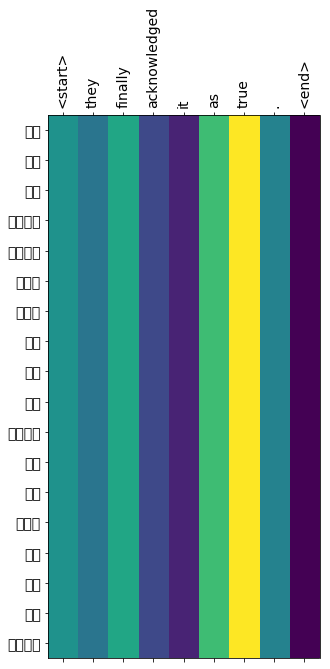

In [61]:
print('grand truth: 彼 ら は つい に それ が 真実 だ と 認め た 。')
translate('they finally acknowledged it as true .')

grand truth: 彼 は 水泳 が 得意 で は な かっ た 。
Input: <start> he didn 't care for swimming . <end>
Predicted translation: １８ 捧げ 不運 タンポン 走り読み さらに 乗り出 まろやか 女王 試着 泰然 栄え 判明 ゴルフ 光栄 はし 大した 委員 


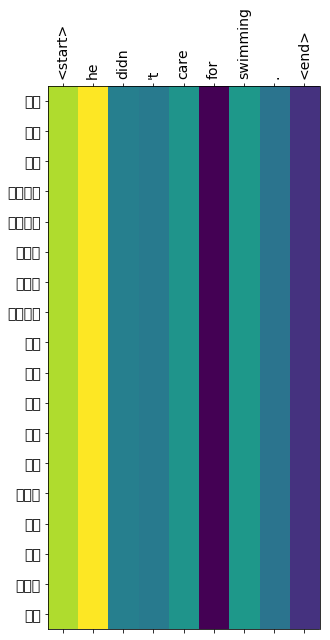

In [35]:
print('grand truth: 彼 は 水泳 が 得意 で は な かっ た 。')
translate("he didn 't care for swimming .")

grand truth: 彼 は お 姉 さん に 劣 ら ず 親切 だ 。
Input: <start> he is no less kind than his sister . <end>
Predicted translation: 婦長 毎食 投げ込 スタート たたき上げ 不足 踏みぬ のけ 本降り ち ぐれ 闇 終始 平易 がらりと 順番 すり切れ 成し遂げ 


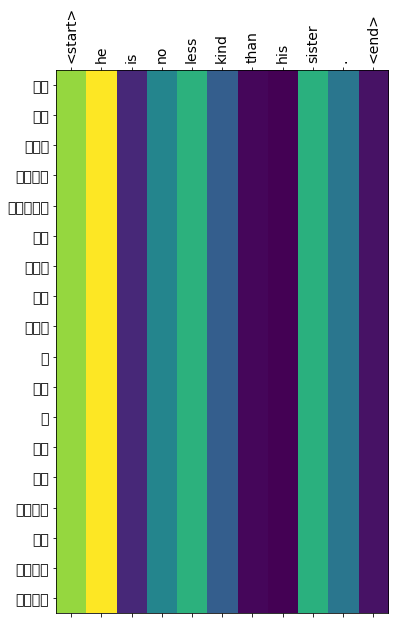

In [36]:
print('grand truth: 彼 は お 姉 さん に 劣 ら ず 親切 だ 。')
translate('he is no less kind than his sister .')

grand truth: １０ 時 前 に 戻 ら な けれ ば な ら な い 。
Input: <start> you must be back before ten . <end>
Predicted translation: １８ 捧げ 賭け 従 かわり ホンダ 純粋 張 はら ちょっと 大目 バス 優勝 かき分け 結末 喧嘩 出港 １８ 


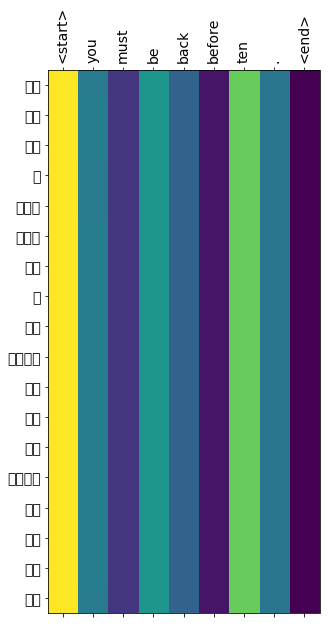

In [37]:
print('grand truth: １０ 時 前 に 戻 ら な けれ ば な ら な い 。')
translate('you must be back before ten .')

# BLEU score

In [38]:
path_test_en = 'small_parallel_enja/test.en'
with open(path_test_en) as f:
    en_test = f.readlines()
en_test = [w.rstrip().strip() for w in en_test]
    
path_test_ja = 'small_parallel_enja/test.ja'
with open(path_test_ja) as f:
    ja_test = f.readlines()
ja_test = [w.rstrip().strip() for w in ja_test]

In [39]:
en_test[0:10]

['they finally acknowledged it as true .',
 "he didn 't care for swimming .",
 'he is no less kind than his sister .',
 'you must be back before ten .',
 'break a leg .',
 'she lives next door to us .',
 "i 'm about to tell you the answer .",
 "i 'm a person who lives for the moment .",
 'we have this game on ice .',
 'will you give me your reasons for doing this ?']

In [40]:
ja_test[0:10]

['彼 ら は つい に それ が 真実 だ と 認め た 。',
 '彼 は 水泳 が 得意 で は な かっ た 。',
 '彼 は お 姉 さん に 劣 ら ず 親切 だ 。',
 '１０ 時 前 に 戻 ら な けれ ば な ら な い 。',
 '成功 を 祈 る わ 。',
 '彼女 は 私 たち の 隣 の 家 に す ん で い る 。',
 'あなた に 返事 を し よ う と し て い る ところ で す 。',
 '私 は 刹那 的 な 生き 方 を し て い る 人間 で す 。',
 'この 試合 は いただ き だ 。',
 'こんな こと を し た 理由 を 言 い な さ い 。']

In [51]:
ja_pred = [evaluate(sentence)[0] for sentence in en_test] ##keyerrorの例外処理を入れる

In [53]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0


In [56]:
ja_pred_l = [sentence.split() for sentence in ja_pred]
ja_test_l = [sentence.split() for sentence in ja_test]

In [58]:
score = [sentence_bleu(reference, candidate) for reference, candidate in zip(ja_test_l,ja_pred_l )]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

In [59]:
score

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8.844844403089351e-232,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8.844844403089351e-232,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8.844844403089351e-232,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8.844844403089351e-232,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
